# Predicting Resale Value of Knives from a Texas Government Surplus Store

## Using Machine Learning to Support an Ebay Store's Financial Success




### Model and Intepret Notebook


**Author:** Dylan Dey
***

# Overview
[Texas State Surplus Store](https://www.tfc.texas.gov/divisions/supportserv/prog/statesurplus/)

[What happens to all those items that get confiscated by the TSA? Some end up in a Texas store.](https://www.wfaa.com/article/news/local/what-happens-to-all-those-items-that-get-confiscated-by-the-tsa-some-end-up-in-a-texas-store/287-ba80dac3-d91a-4b28-952a-0aaf4f69ff95)

[Texas Surplus Store PDF](https://www.tfc.texas.gov/divisions/supportserv/prog/statesurplus/State%20Surplus%20Brochure-one%20bar_rev%201-10-2022.pdf)

![Texas State Surplus Store](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRYkwyu20VBuQ52PrXdVRaGRIIg9OPXJg86lA&usqp=CAU)



Thousands of people make a living selling pre-owned items on sites like EBay. A good place to locate items for sale is the Texas Facilities Commission collects left behind possessions, salvage, and surplus from Texas state agencies such as DPS, TXDOT, TCEQ, and Texas Parks & Wildlife. Examples of commonly available items include vehicles, furniture, office equipment and supplies, small electronics, and heavy equipment. The goal of this project is to create a predictive model in order to determine the resale value of knives from the Texas State Surplus Store on eBay. Descriptive analysis of over 70K sold knives on eBay in the last 2 years will also be used to examine the profitability of investing in knives from the surplus store. 


# BUSINESS PROBLEM
[Texas Dave's Knives](https://www.ebay.com/str/texasdave3/Knives/_i.html?store_cat=3393246519)

 My family has been running a resale shop and selling on Ebay and other sites for years and lately the business has picked up. We are interested in exploring if the most common item sold at the Texas Surplus Store, pocket knives, would be a safe investment. On the surface they seem great for reselling, as they are oftentimes collectible and small enough to be easily shipped. 

I have been experimenting with low cost used knives for resale but have not risked a large capital investment in the higher end items. Analyzing past listings on eBay for the top brands available at the Surplus Store could prove useful for gaining insight on whether a larger investment would pay off. Understanding the risks involved in investing capital into different brands of knives and their potential returns will help narrow down what brands to invest in and help reduce excess inventory.

It has been very time consuming and inaccurate trying to find the correct value to list an item for on eBay. Currently when listing we try to identify the specific knife by Google search, and then try to find the same or similar items sold on Ebay or other sites. This “guess and check” method often results in inventory not moving due to overpricing or being sold at a price lower than its true potential profit. Building a model that predicts the value of a pocket knife on eBay could help to easily determine the correct value of the item before a listing is live on the website.



# Data Understanding

> There are <mark>eight buckets of presorted brand knives</mark> that I was interested in exploring from the Texas Surplus Store. The Eight Pocketknife brands and their associated cost at the Texas Surplus Store:

<ul>
  <li>Benchmade: \$45.00</li>
  <li>Buck: \$20.00</li>
  <li>Case/Casexx: \$20.00</li>
  <li>CRKT: \$15.00</li>
  <li>Kershaw: \$15.00</li>
  <li>SOG: \$15.00</li>
  <li>Spyderco: \$30.00</li>
  <li>Victorinox: \$20.00</li>
</ul>

### Domain Understading: Cost Breakdown
- padded envelopes: \$0.50 per knife
- flatrate shipping: \$4.45 per knife
- brand knife at surplus store: 15, 20, 30, or 45 dollars per knife
- overhead expenses (gas, cleaning suplies, sharpening supplies, etc): \$3.00
- Ebay's comission, with 13\% being a reasonable approximation

>A majority of the data was scraped from eBays proprietary Terapeak webapp, as this data goes back 2 years as compared to the API listed data that only goes back 90 days. It is assumed a large enough amount of listed data should approximate sold data well enough to prove useful for this project. 

> The target feature for the model to predict is the total price (shipping included) that a knife should be listed on eBay. One model will be using titles and images in order to find potential listings that are undervalued and could be worth investing in. Another model will accept only images as input, as this is an input that can easily be obtained in person at the store. This model will use past sold data of knives on eBay in order to determine within an acceptable amount of error the price it will resale for on eBay (shipping included) using only an image

In [1]:
from sklearn.model_selection import train_test_split
import os
from collections import Counter

import pandas as pd 
import  json
import requests
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import ast
import re

import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding, Flatten, GRU
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.models import Model
from keras import models
from keras import layers
import tensorflow as tf
from keras.utils import plot_model
from sklearn.metrics import mean_absolute_error
from keras_preprocessing.image import ImageDataGenerator

In [2]:
#helps see plots in readme
plt.style.use('dark_background')

### Function Definition

Define functions to import and clean data for modeling.

In [3]:
def apply_iqr_filter(df):
    
    price_Q1 = df['converted_price'].quantile(0.25)
    price_Q3 = df['converted_price'].quantile(0.75)
    price_iqr = price_Q3 - price_Q1

    profit_Q1 = df['profit'].quantile(0.25)
    profit_Q3 = df['profit'].quantile(0.75)
    profit_iqr = profit_Q3 - profit_Q1

    ROI_Q1 = df['ROI'].quantile(0.25)
    ROI_Q3 = df['ROI'].quantile(0.75)
    ROI_iqr = ROI_Q3 - ROI_Q1

    price_upper_limit = price_Q3 + (1.5 * price_iqr)
    price_lower_limit = price_Q1 - (1.5 * price_iqr)

    profit_upper_limit = profit_Q3 + (1.5 * profit_iqr)
    profit_lower_limit = profit_Q1 - (1.5 * profit_iqr)

    ROI_upper_limit = ROI_Q3 + (1.5 * ROI_iqr)
    ROI_lower_limit = ROI_Q1 - (1.5 * ROI_iqr)
    
#     print(f'Brand: {df.brand[0]}')
#     print(f'price upper limit: ${np.round(price_upper_limit,2)}')
#     print(f'price lower limit: ${np.round(price_lower_limit,2)}')
#     print('-----------------------------------')
#     print(f'profit upper limit: ${np.round(profit_upper_limit,2)}')
#     print(f'profit lower limit: ${np.round(profit_lower_limit,2)}')
#     print('-----------------------------------')
#     print(f'ROI upper limit: {np.round(ROI_upper_limit,2)}%')
#     print(f'ROI lower limit: {np.round(ROI_lower_limit,2)}%')
#     print('-----------------------------------')

    
    new_df = df[(df['converted_price'] < price_upper_limit) &
                (df['converted_price'] > price_lower_limit) &
                (df['profit'] < profit_upper_limit) &
                (df['ROI'] > profit_lower_limit) &
                (df['profit'] < ROI_upper_limit) &
                (df['ROI'] > ROI_lower_limit)]
    
    return new_df
#download jpg urls from dataFrame
def download(row):
    filename = os.path.join(root_folder, str(row.name) + im_extension)

# create folder if it doesn't exist
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    url = row.Image
#     print(f"Downloading {url} to {filename}")
    
    try:
        r = requests.get(url, allow_redirects=True)
        with open(filename, 'wb') as f:
            f.write(r.content)
    except:
        print(f'{filename} error')



# This function removes noisy data
#lots/sets/groups of knives can
#confuse the model from predicting
#the appropriate value of individual knives
def data_cleaner(df):
    lot = re.compile('(?<!-\S)lot(?![^\s.,:?!])')
    group = re.compile('(group)')
    is_set = re.compile('(?<!-\S)set(?![^\s.,?!])')
    df['title'] = df['title'].str.lower()
    trim_list = [lot,group,is_set]
    for item in trim_list:
        df.loc[df['title'].apply(lambda x: re.search(item, x)).notnull(), 'trim'] = 1 
    to_drop = df.loc[df['trim'] == 1].index
    df.drop(to_drop, inplace=True)
    df.drop('trim', axis=1, inplace=True)
    
    return df


#take raw data and prepare it for modeling
def prepare_listed(listed_data_df):
    listed_used_knives = listed_data_df.loc[listed_data_df['condition'] != 1000.0]
    listed_used_knives = data_cleaner(listed_used_knives.copy())
    listed_used_knives.reset_index(drop=True, inplace=True)
    
    return listed_used_knives

#take raw data and prepare it for modeling
def prepare_tera_df(df, x, overhead_cost=3):
    df['price_in_US'] = df['price_in_US'].str.replace("$", "")
    df['price_in_US'] = df['price_in_US'].str.replace(",", "")
    df['price_in_US'] = df['price_in_US'].apply(float)
    
    df['shipping_cost'] = df['shipping_cost'].str.replace("$", "")
    df['shipping_cost'] = df['shipping_cost'].str.replace(",", "")
    df['shipping_cost'] = df['shipping_cost'].apply(float)
    
    df['brand'] = list(bucket_dict.keys())[x]
    df['converted_price'] = (df['price_in_US'] + df['shipping_cost'])
    df['cost'] = list(bucket_dict.values())[x] + overhead_cost + 4.95
    df['profit'] = ((df['converted_price']*.87) -  df['cost'])
    df['ROI'] = (df['profit']/ df['cost'])*100.0
    
    return df   


def avg_word_len(x):
    words = x.split()
    word_len = 0
    for word in words:
        word_len += len(word)
        
    return word_len / len(words)

The above code imports a variety of libraries and packages to help with data manipulation and analysis. It also defines a few functions to help with pagination, data preparation, and image download. The main logic of the code is in the knife_request() function which makes API calls to eBay using the ebaysdk.finding Connection function. The function prepares data, creates a new feature, and prepares the brands. The download() function downloads images from URLs.

### Load Data

In [4]:
cd ..

/Users/dylandey/Documents/GitHub/Neural_Network_Predicting_Reseller_Success_Ebay


In [5]:
#load Finding API data
df_bench = pd.read_csv("listed_data/df_bench.csv")
df_buck = pd.read_csv("listed_data/df_buck.csv")
df_case = pd.read_csv("listed_data/df_case.csv")
df_caseXX = pd.read_csv("listed_data/df_CaseXX.csv")
df_crkt = pd.read_csv("listed_data/df_crkt.csv")
df_kersh = pd.read_csv("listed_data/df_kershaw.csv")
df_sog = pd.read_csv("listed_data/df_sog.csv")
df_spyd = pd.read_csv("listed_data/df_spyderco.csv")
df_vict = pd.read_csv("listed_data/df_victorinox.csv")


#Load scraped terapeak sold data
sold_bench = pd.read_csv("terapeak_data/bench_scraped2.csv")
sold_buck1 = pd.read_csv("terapeak_data/buck_scraped2.csv")
sold_buck2 = pd.read_csv("terapeak_data/buck_scraped2_reversed.csv")
sold_case = pd.read_csv("terapeak_data/case_scraped2.csv")
sold_caseXX1 = pd.read_csv("terapeak_data/caseXX_scraped2.csv")
sold_caseXX2 = pd.read_csv("terapeak_data/caseXX2_reversed.csv")
sold_crkt = pd.read_csv("terapeak_data/crkt_scraped.csv")
sold_kershaw1 = pd.read_csv("terapeak_data/kershaw_scraped2.csv")
sold_kershaw2 = pd.read_csv("terapeak_data/kershaw_scraped2_reversed.csv")
sold_sog = pd.read_csv("terapeak_data/SOG_scraped2.csv")
sold_spyd = pd.read_csv("terapeak_data/spyd_scraped2.csv")
sold_vict1 = pd.read_csv("terapeak_data/vict_scraped.csv")
sold_vict2 = pd.read_csv("terapeak_data/vict_reversed.csv")

sold_list = [sold_bench,sold_buck1,
             sold_buck2,sold_case,
             sold_caseXX1,sold_caseXX2,
             sold_crkt,sold_kershaw1,
             sold_kershaw2,sold_sog, 
             sold_spyd, sold_vict1,
             sold_vict2]


listed_df = pd.concat([df_bench,df_buck,
                       df_case,df_caseXX,
                       df_crkt,df_kersh,
                       df_sog,df_spyd,
                       df_vict])

used_listed = prepare_listed(listed_df)

bucket_dict = {'benchmade': 45.0,
               'buck': 20.0,
               'case': 20.0,
               'crkt': 15.0,
               'kershaw': 15.0,
               'sog': 15.0,
               'spyderco': 30.0,
               'victorinox': 20.0
               }

### Prepare Data

This code loads data from several CSV files into Pandas dataframes and prepares the data for analysis.

1) The first block of code loads 9 dataframes of listed knife data (df_bench, df_buck, df_case, df_caseXX, df_crkt, df_kersh, df_sog, df_spyd, df_vict) from 9 corresponding CSV files.


2) The second block of code loads 12 dataframes of sold knife data (sold_bench, sold_buck1, sold_buck2, sold_case, sold_caseXX1, sold_caseXX2, sold_crkt, sold_kershaw1, sold_kershaw2, sold_sog, sold_spyd, sold_vict1, sold_vict2) from 12 corresponding CSV files. All 12 dataframes are then combined into a list called sold_list.

3) The code then concatenates the 9 listed knife dataframes into one dataframe called listed_df.

4) The function prepare_listed is applied to the listed_df dataframe.

5) The code then creates a dictionary called bucket_dict which maps knife brands to a price bucket.

6) The next block of code renames the 'Text' and 'shipping_' columns in each of the 12 sold dataframes to 'title' and 'shipping_cost', respectively.

7) The code then converts the 'date_sold' column in each of the 12 sold dataframes to a datetime type.

8) The code then concatenates the two dataframes sold_buck1 and sold_buck2 into one dataframe called sold_buck. The same is done for sold_caseXX, sold_kershaw, and sold_vict.

9) The prepare_tera_df function is applied to each of the 6 updated sold dataframes (sold_bench, sold_buck, sold_case, sold_caseXX, sold_crkt, sold_kershaw, sold_sog, sold_spyd, sold_vict) to remove characters from the price column and create new profit/ROI features.

In [6]:
for dataframe in sold_list:
    dataframe.rename({'Text': 'title',
                      'shipping_': 'shipping_cost'},
                     axis=1, inplace=True)

    dataframe['date_sold'] = pd.to_datetime(dataframe['date_sold'])

#limited out at 10K columns while scraping. Combine dataframes that went over 10K.
sold_buck = pd.concat([sold_buck1,sold_buck2])
sold_caseXX = pd.concat([sold_caseXX1,sold_caseXX2])
sold_kershaw = pd.concat([sold_kershaw1,sold_kershaw2])
sold_vict = pd.concat([sold_vict1,sold_vict2])

#apply function to remove characters from price
#and create profit/ROI features
sold_bench = prepare_tera_df(sold_bench, 0)
sold_buck = prepare_tera_df(sold_buck, 1)
sold_case = prepare_tera_df(sold_case, 2)
sold_caseXX = prepare_tera_df(sold_caseXX, 2)
sold_crkt = prepare_tera_df(sold_crkt, 3)
sold_kershaw = prepare_tera_df(sold_kershaw, 4)
sold_sog = prepare_tera_df(sold_sog, 5)
sold_spyd = prepare_tera_df(sold_spyd, 6)
sold_vict = prepare_tera_df(sold_vict, 7)

In [7]:
#lowercase and strip titles and remove duplicates
for dataframe in sold_list:
    dataframe['title'] = dataframe['title'].str.lower()
    dataframe['title'] = dataframe['title'].str.strip()
    dataframe.drop_duplicates(
        subset = ['date_sold','price_in_US', 
                  'shipping_cost'],
        keep = 'last', inplace=True)

In [8]:
sold_df = pd.concat([sold_bench, sold_buck,
                     sold_case, sold_caseXX, 
                     sold_crkt, sold_kershaw,
                     sold_sog, sold_spyd,
                     sold_vict]) 
#remove lots
sold_knives = data_cleaner(sold_df).copy()

#combine data
df = pd.concat([sold_knives,used_listed]).copy()
df['Image'].fillna(df['pictureURLLarge'], inplace=True)

#apply IQR filtering
df = apply_iqr_filter(df).copy()
df.reset_index(drop=True, inplace=True)

#### Text Preprocessing

In [9]:
#load stopwords 
from nltk.corpus import stopwords
stop = stopwords.words('english')
#remove any special characters
def remove_special_char(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return text

def remove_punctuations(x):
    x.translate(str.maketrans('', '', string.punctuation))
    return x
#apply above functions to dataframe
def apply_text_prep(df):

    df['title'] = df['title'].apply(remove_punctuations)
    df['title'] = df['title'].apply(remove_special_char)
    #A lot of the strings had duplicate phrases
    #create a set on split strings in order to
    #only get unique words in each title
    df['title'] = df['title'].apply(lambda s: ' '.join(list(set(s.split()))))


    df['title_len'] = df['title'].apply(lambda x: len(x))
    df['word_count'] = df['title'].apply(lambda x: len(x.split()))
    df['avg_word_len'] = df['title'].apply(lambda x: avg_word_len(x))

    stop = stopwords.words('english')

    df['title_nostop'] = df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
    
    return df
df = apply_text_prep(df)

# Model

## Neural network with "title" column as input

>A title is something that is essential when posting an item for sale on eBay. A lot of sellers use the same format for titles depending on the product. Titles on eBay are essentially a list of keywords in order to promote it higher in the algorathim. Each knife brand and model combination have features that are desirable to collectors that sellers want to put right up at the top of their listing. 

>Pricing a certain pocketknife correctly when listing it, however, is time consuming and requires scrolling through webpages trying to find the most similar knives and guessing what would be competitive while hoping that none of your filters reset or you didnt miss a cruicial one. Pricing the item correctly is very important. If you post the item for sale too low, it might sell quickly and avoid excess inventory piling up, but it is also leaving revenue on the table. Listing the knife too high would mean it may not move off the shelf at all. 

>Creating a model to predict the price to list a knife for sale and accurately determing it's true resale value can not only save time and make listing items more efficient, it can also optimize for an equilibrium between excess inventory and lost revenue. 

>A number of different vectorization methods and modeling was tested for this project. The appendix has some brief examples of training a Random Forest model with feature importances and TfIDF vectorization. This type of vectorization, like one-hot tend to be very sparse for NLP. An advantage over this type of reperesentation is Word-embeddings: a learned represntation for text where words that have similar meaning have similar representation. Word embeddings are dense, lower-dimensional and learned from the data.

>Recurrent Neural Networks are a type of Neural Network in which the output from the previous step is fed as input to the current step, making it well suited for handling sequence data. 

>RNNs are particularly useful if the prediction has to be at word-level, as it stores the information for current feature as well neighboring features for prediction. A RNN maintains a memory based on history information. A simple RNN, however, has a "short" memory and can often lead into problems with vanishing gradients. LSTM were created to use gates in order to filter for feature importance in order to combat this problem. This makes them better at finding and exposing long range dependencies in data which is imperative for sentence structures.

>LSTMs are a bit more complex than GRU, with 3 gates compared to 2 for the GRU. GRUs are relatively new compared to LSTMs and their performance is on par with them, but computationally more efficient (as pointed out, they have a less complex structure).

>See below for model creation and hyperparameter tuning for different RNN architectures, inluding LSTMs and GRUs.

In [10]:
from tensorboard.plugins.hparams import api as hp

<AxesSubplot:title={'center':'Word Count Distribution'}, ylabel='Frequency'>

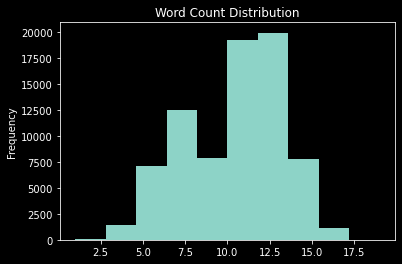

In [11]:
df['word_count'].plot(kind = 'hist', title = 'Word Count Distribution')

<AxesSubplot:title={'center':'Avg_Word_len Distribution'}, ylabel='Frequency'>

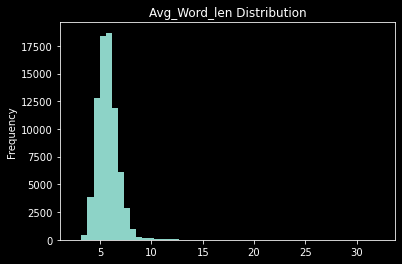

In [12]:
df['avg_word_len'].plot(kind='hist', bins = 50, title = 'Avg_Word_len Distribution')

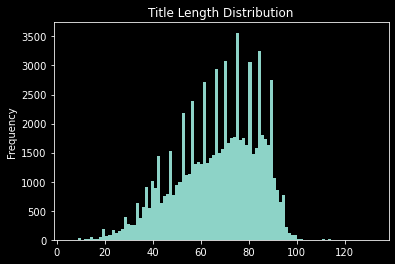

In [13]:
df['title_len'].plot(kind='hist', bins= 100,title = 'Title Length Distribution');

## simpleRNN

The mean max sequence for is not that long for eBay titles, thus a simpleRNN was tested to see if architecture with gates could be avoided to increase efficiency. Hyperparameter tuning is shown below. The best performing model had 100.00 units and dropout=0.4 in the RNN layer with a test MAE of 14.869. Different variations of max sequence length, vocab size, and number of embedding features was tested as well. Performed well but not as well as GRU model.


In [14]:
df_title = df.loc[:, ['title_nostop', 'converted_price']]


df_title.rename({'title_nostop': 'data',
                 'converted_price': 'labels'},
                axis=1, inplace=True)

In [15]:
df_title.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76914 entries, 0 to 76913
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   data    76914 non-null  object 
 1   labels  76914 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.2+ MB


In [16]:
df_title['labels'].mean()

49.993376628442164

Split data into training and testing sets and the split the testing set to create equal size val and train sizes.

In [17]:
# df_title['labels'] = (df_title['labels']/mean_price)
y = df_title['labels'].values
X_train, X_test, y_train, y_test = train_test_split(df_title['data'],
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [18]:
X_val, X_test, y_val, y_test = train_test_split(X_test, 
                                                y_test, 
                                                test_size=0.5, 
                                                random_state=42)

In [ ]:
#Vectorize vocab 
voc_size = 10000
max_len = 10
embedding_features = 300
tokenizer = Tokenizer(num_words=voc_size, oov_token = '<OOV>')
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train) 
sequences_val = tokenizer.texts_to_sequences(X_val)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
#add padding to ensure all inputs are the same size
data_train = pad_sequences(sequences_train, maxlen=max_len, padding= 'post', truncating = 'post')
data_val = pad_sequences(sequences_val, maxlen=max_len, padding= 'post', truncating = 'post')
data_test = pad_sequences(sequences_test, maxlen=max_len, padding= 'post', truncating = 'post')

In [ ]:
data_train.shape

In [ ]:
model = models.Sequential()
model.add(Embedding(voc_size, embedding_features, input_length = max_len)) 
model.add(GRU(100,dropout=0.3))
model.add(Dense(1, activation = 'linear'))
model.summary()

In [ ]:
# Compile and fit
model.compile(
  loss='MSE',
  optimizer='adam',
  metrics=['mae']
)


print('Training model...')
r = model.fit(
  data_train,
  y_train,
  epochs=5,
  validation_data=(data_val, y_val)
)

In [ ]:
#set values for hyperparamter testing of simpleRNN model
HP_NUM_UNITS = hp.HParam('units', hp.Discrete([64,100,300,600]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.2,0.4))


METRIC_MAE = 'MAE'
#set metrics
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS, HP_DROPOUT],
        metrics=[hp.Metric(METRIC_MAE, display_name='MAE')],
    )

In [ ]:
#create model for hyperparameter testing
def train_test_model(hparams):
    model = models.Sequential()
    model.add(Embedding(voc_size, embedding_features, input_length = max_len)) 
    model.add(SimpleRNN(hparams[HP_NUM_UNITS],dropout=(hparams[HP_DROPOUT])))
    model.add(Dense(1, activation = 'linear'))
    model.compile(
      optimizer='Adam',
      loss='MSE',
      metrics=['MAE'],
    )
    model.fit(data_train, 
              y_train, 
              epochs=5,
              validation_data=(data_val, y_val)
             )
    _, MSE = model.evaluate(data_test, y_test)
    return MSE

In [ ]:
#write files
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        MSE = train_test_model(hparams)
        tf.summary.scalar(METRIC_MAE, MSE, step=1)

In [ ]:
# %load_ext tensorboard

In [ ]:
# rm -rf ./logs/

In [ ]:
#run hyperparamter testing for simpleRNN Model
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run('logs/hparam_tuning/' + run_name, hparams)
        session_num += 1

[simpleRNN Hyperparamter Optimization](https://tensorboard.dev/experiment/sngivEMGR2KSgnBDe3ncLQ)

### GRU
An alternative to creating a simpleRNN layer after embedding is to use a GRU layer. The architecture of this layer is more efficient than an LSTM, but it is similar in its ability to filter features by importance before continuing in the network. This ability helps to fight short term memory and vanishing gradients. This usually works well with smaller sample size than more robust LSTM models. However, for this project the GRU model performed the best with a test MAE of 14.28. 

In [ ]:
#Vectorize vocab 
voc_size = 30000
max_len = 11
embedding_features = 100
tokenizer = Tokenizer(num_words=voc_size, oov_token = '<OOV>')
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train) 
sequences_val = tokenizer.texts_to_sequences(X_val)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
#add padding to ensure all inputs are the same size
data_train = pad_sequences(sequences_train, maxlen=max_len, padding= 'post', truncating = 'post')
data_val = pad_sequences(sequences_val, maxlen=max_len, padding= 'post', truncating = 'post')
data_test = pad_sequences(sequences_test, maxlen=max_len, padding= 'post', truncating = 'post')

In [ ]:
data_train.shape

In [ ]:
#setup units for hyperparameter testing
HP_NUM_UNITS = hp.HParam('units', hp.Discrete([64,100,300,600]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.2,0.4))


METRIC_MAE = 'MAE'
#log performance
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS, HP_DROPOUT],
        metrics=[hp.Metric(METRIC_MAE, display_name='MAE')],
    )

In [ ]:
#define model for hyperparameter testing
def train_test_model(hparams):
    model = models.Sequential()
    model.add(Embedding(voc_size, embedding_features, input_length = max_len)) 
    model.add(GRU(hparams[HP_NUM_UNITS],dropout=(hparams[HP_DROPOUT])))
    model.add(Dense(1, activation = 'linear'))
    model.compile(
      optimizer='Adam',
      loss='MSE',
      metrics=['MAE'],
    )
    model.fit(data_train, 
              y_train, 
              epochs=5,
              validation_data=(data_val, y_val)
             )
    _, MSE = model.evaluate(data_test, y_test)
    return MSE

In [ ]:
#write files
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        MSE = train_test_model(hparams)
        tf.summary.scalar(METRIC_MAE, MSE, step=1)

In [ ]:
# %load_ext tensorboard

In [ ]:
# rm -rf ./logs/

In [ ]:
#run hyperparamter testing for GRU Model
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run('logs/hparam_tuning/' + run_name, hparams)
        session_num += 1

In [ ]:
%tensorboard --logdir logs/hparam_tuning

[GRU Hyperparameter tuning](https://tensorboard.dev/experiment/k0ny5jh6Tvm8OALWMwBkWQ/#hparams)

In [19]:
#Vectorize vocab 
voc_size = 30000
max_len = 11
embedding_features = 100
tokenizer = Tokenizer(num_words=voc_size, oov_token = '<OOV>')
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train) 
sequences_val = tokenizer.texts_to_sequences(X_val)
sequences_test = tokenizer.texts_to_sequences(X_test)

#add padding to ensure all inputs are the same size
data_train = pad_sequences(sequences_train, maxlen=max_len, padding= 'post', truncating = 'post')
data_val = pad_sequences(sequences_val, maxlen=max_len, padding= 'post', truncating = 'post')
data_test = pad_sequences(sequences_test, maxlen=max_len, padding= 'post', truncating = 'post')

In [20]:
model = models.Sequential()
model.add(Embedding(voc_size, embedding_features, input_length = max_len)) 
model.add(GRU(100,dropout=0.4))
model.add(Dense(1, activation = 'linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 11, 100)           3000000   
_________________________________________________________________
gru (GRU)                    (None, 100)               60600     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 3,060,701
Trainable params: 3,060,701
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile and fit
model.compile(
  loss='MSE',
  optimizer='adam',
  metrics=['mae']
)


print('Training model...')
r = model.fit(
  data_train,
  y_train,
  epochs=5,
  validation_data=(data_val, y_val)
)

Training model...
Epoch 1/5
1683/1683 [==============================] - 41s 24ms/step - loss: 1088.0472 - mae: 22.9519 - val_loss: 553.6788 - val_mae: 16.2353
Epoch 2/5
1683/1683 [==============================] - 41s 24ms/step - loss: 466.1590 - mae: 14.8689 - val_loss: 457.7079 - val_mae: 14.7498
Epoch 3/5
1683/1683 [==============================] - 41s 24ms/step - loss: 356.8253 - mae: 12.7989 - val_loss: 446.2110 - val_mae: 14.2553
Epoch 4/5
1683/1683 [==============================] - 39s 23ms/step - loss: 301.8997 - mae: 11.6065 - val_loss: 451.4138 - val_mae: 14.0694
Epoch 5/5
1661/1683 [============================>.] - ETA: 0s - loss: 266.8204 - mae: 10.7925

In [ ]:
s1 = "Spyderco Mantra 3 Liner Lock Knife Black Carbon Fiber & G-10 S30V Steel C233CFP"
s1_p = 136.1
s2 = "Benchmade 556 Green 154cm Combo Blade Pardue Design"
s2_p = 71.95
s3 = "Case XX 6207 SS Mini Trapper Brown Peachseed Bone Pocket Knife Made in Usa"
s3_p = 51.45

In [ ]:
def test_single_string(s):
    s = remove_special_char(s.lower())
    s = remove_punctuations(s)
    s = ' '.join(list(set(s.split())))
    test = tokenizer.texts_to_sequences([s])
    test2 = pad_sequences(test, maxlen=max_len, padding= 'post', truncating = 'post')
    pred=model.predict(test2)
    return pred

In [ ]:
pred1 = test_single_string(s1)[0][0]
pred2 = test_single_string(s2)[0][0]
pred3 = test_single_string(s3)[0][0]

![sample1](images/RNN/randomSpyd.jpeg)
![sample2](images/RNN/randomBench.jpeg)
![sample3](images/RNN/randomCase.jpeg)

In [ ]:
print(f'True value: ${s1_p}, Predicted Value: ${pred1:.2f}, difference: ${pred1 - s1_p:.2f}')
print(f'True value: ${s2_p}, Predicted Value: ${pred2:.2f} difference: ${pred2 - s2_p:.2f}')
print(f'True value: ${s3_p}, Predicted Value: ${pred3:.2f} difference: ${pred3 - s3_p:.2f}')

In [ ]:
preds =model.predict(data_test)

In [ ]:
preds = preds.reshape(len(preds))

In [ ]:
test_results = model.evaluate(data_test, y_test)

In [ ]:
fig = plt.subplots(figsize=(12,8))
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.title("Loss vs val Loss for RNN model on titles (MSE)", fontsize=15)
plt.xlabel("epochs", fontsize=15)
plt.ylabel("loss (mean squared error)", fontsize=15)
plt.legend();
plt.savefig('images/RNN/RNN_GRU_MSE1.png')

In [ ]:
fig = plt.subplots(figsize=(12,8))
plt.plot(r.history['mae'], label='mae')
plt.plot(r.history['val_mae'], label='val_mae')
plt.title("Loss vs val Loss for RNN model on titles (MAE)", fontsize=15)
plt.xlabel("epochs", fontsize=15)
plt.ylabel("loss (mean absolute error)", fontsize=15)
plt.legend();
plt.savefig('images/RNN/RNN_GRU_MAE1.png')

In [ ]:
plot_model(model,show_shapes=True, to_file='images/RNN/RNN_GRU1_arc.png')

In [ ]:
test_mae = mean_absolute_error(y_test, preds)

In [ ]:
RMSE = np.sqrt(test_results[0])

In [ ]:
string_score = f'\nMAE on training set: ${test_mae:.2f}'
string_score += f'\nRMSE on training set: ${RMSE:.2f}'
fig, ax = plt.subplots(figsize=(12, 8))
plt.scatter(y_test, preds)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.text(3, 150, string_score)
plt.title('RNN Model for Predicting Resale Value')
plt.ylabel('Model predictions for Resale Value($US)')
plt.xlabel('True Values for Resale Value($US)')
plt.show();
# plt.savefig('images/regression_GRU_relu1.png');

In [ ]:
plt.figure(figsize=(12,8))

ax = sns.regplot(x=y_test,y=preds,marker='.')
plt.title('Regression Plot for RNN Model Performance on Predicting Resale Value',
         fontsize=20)
plt.ylabel('Model predictions for Resale Value($US)',
          fontsize=18)
plt.xlabel('True Values for Resale Value($US)',
          fontsize=18)
plt.xticks([20,40,
            60,80,
            100,120,
            140,160],
           ['$20.00','$40.00',
            '$60.00','$80.00',
            '$100.00','$120.00',
            '$140.00','$160.00'],
          fontsize=15)
plt.yticks([20,40,
            60,80,
            100,120,
            140],
           ['$20.00','$40.00',
            '$60.00','$80.00',
            '$100.00','$120.00',
            '$140.00'],
          fontsize=15)
plt.savefig('images/RNN/regPlot_GRU_performance.png');

In [ ]:
test_mae

### LSTM

In [ ]:
df_title = df.loc[:, ['title_nostop', 'converted_price']]


df_title.rename({'title_nostop': 'data',
                 'converted_price': 'labels'},
                axis=1, inplace=True)

In [ ]:
# df_title['labels'] = (df_title['labels']/mean_price)
Y = df_title['labels'].values

In [ ]:
df_train, df_test, Ytrain, Ytest = train_test_split(df_title['data'],
                                                    Y, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [ ]:
X_val, X_test, Y_val, Y_test = train_test_split(df_test, 
                                                Ytest, 
                                                test_size=0.5, 
                                                random_state=42)

In [ ]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 30000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE) 
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train) 
sequences_val = tokenizer.texts_to_sequences(X_val) 
sequences_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

In [ ]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

In [ ]:
data_val = pad_sequences(sequences_val, maxlen=T)
print('Shape of data test tensor:', X_val.shape)

In [ ]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', X_test.shape)

In [ ]:
HP_NUM_UNITS = hp.HParam('units', hp.Discrete([16,32,64,100,300]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.2,0.4))


METRIC_MAE = 'MAE'

with tf.summary.create_file_writer('logs/hparam_tuning2').as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS, HP_DROPOUT],
        metrics=[hp.Metric(METRIC_MAE, display_name='MAE')],
    )

In [ ]:
D = 11

def train_test_model(hparams):
    i = Input(shape=(T,))
    x = Embedding(V + 1, D)(i)
    x = LSTM(hparams[HP_NUM_UNITS],dropout=(hparams[HP_DROPOUT]),return_sequences=True)(x) 
    x = GlobalMaxPooling1D()(x)
    x = Dense(1, activation='linear')(x)
    model = Model(i, x)
    model.compile(
      optimizer='Adam',
      loss='MSE',
      metrics=['MAE'],
    )
    model.fit(data_train, 
              y_train, 
              epochs=5,
              validation_data=(data_val, y_val)
             )
    _, MSE = model.evaluate(data_test, y_test)
    return MSE

In [ ]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        MSE = train_test_model(hparams)
        tf.summary.scalar(METRIC_MAE, MSE, step=1)

In [ ]:
# %reload_ext tensorboard

In [ ]:
# rm -rf ./logs/

In [ ]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run('logs/hparam_tuning2/' + run_name, hparams)
        session_num += 1

In [ ]:
df_title.describe()

[LSTM Hyperparameter Tuning](https://tensorboard.dev/experiment/TmUjuPT7RGCVp0dZ2pwUPQ/)
The Tensorboard above summarizes some hyperaparmeter optimization for the LSTM Network.

# Business Recommendations
<div class = "alert alert-success">
    <p> Deploying use of the GRU Price Predictive Model while listing a knife for resale can not only save time for the lister but can also help optimize for the correct price to list the knife which can balance between listing the knife too low and losing potential revenue or pricing the knife to high and creating inventory that stagnates on the shelf. The model should help balance excess inventory costs for too high of prices vs loss revenue caused by pricing the item correctly. 
    
Based on the statistics of the dataset, the range of knife prices on eBay is quite large, from 6.95 USD to 166.50 USD. The mean price of 49.99 USD and median price of 38.86 USD indicate that the prices are skewed towards the lower end, but with a standard deviation of 35.84 USD, there is still a significant spread of prices.

The performance of the Recurrent Neural Network (RNN) can be evaluated by comparing its prediction error to the spread of prices in the dataset. With an absolute error of 14.28 USD, the RNN is able to accurately predict the price within a range of approximately 29.57 USD (14.28 USD * 2). This is relatively close to the range of prices in the 25th to 75th percentile (22.25 to 67.29 USD).

Therefore, the performance of the RNN can be considered decent, especially given the large range of prices in the dataset.
    
**Summary: I reccomend deploying the Price Predicting Model before posting a pocket knife for sale on eBay.**
    </p>
</div>

![regPlot GRU](https://github.com/ddey117/Neural_Network_Predicting_Reseller_Success_Ebay/blob/master/images/RNN/regPlot_GRU_performance.png?raw=true)

### CNN Titles

In [ ]:
# Create the CNN model

# We get to choose embedding dimensionality
D = 100



i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Dense(1, activation='linear')(x)

model = Model(i, x)

In [ ]:
# Compile and fit
model.compile(
  loss='MSE',
  optimizer='adam',
  metrics=['mae']
)


print('Training model...')
r = model.fit(
  data_train,
  Ytrain,
  epochs=5,
  validation_data=(data_val, y_val)
)


In [ ]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend();

In [ ]:
# Plot accuracy per iteration
plt.plot(r.history['loss'], label='MSE')
plt.plot(r.history['val_loss'], label='val_MSE')
plt.legend();

### CNN using images as input

In [ ]:
df_imgs = df.drop(['title', 'url', 
                   'date_sold', 'profit',
                   'ROI', 'brand', 'cost',
                   'pictureURLLarge'],
                     axis=1).copy()

In [ ]:
df_imgs.dropna(subset=['Image'], inplace=True)

In [ ]:
df_imgs.reset_index(drop=True, inplace=True)

In [ ]:
df_imgs['file_index'] = df_imgs.index.values
df_imgs['file_index'] = df_imgs['file_index'].astype(str)

In [ ]:
df_imgs['filename'] = df_imgs['file_index'] + '.jpg'

In [ ]:
def download(row):
    filename = row.filepath

# create folder if it doesn't exist
#     os.makedirs(os.path.dirname(filename), exist_ok=True)

    url = row.Image
#     print(f"Downloading {url} to {filename}")
    
    try:
        r = requests.get(url, allow_redirects=True)
        with open(filename, 'wb') as f:
            f.write(r.content)
    except:
        print(f'{filename} error')

In [ ]:
root_folder = 'C:/Users/12108/Documents/GitHub/Neural_Network_Predicting_Reseller_Success_Ebay/nn_images/'
df_imgs['filepath'] = root_folder + df_imgs['filename']

In [ ]:
df_imgs['filepath'].sample(2).apply(print)

In [ ]:
# df_imgs.apply(download, axis=1)

#### All image files are stored locally for this project. The below markdown code is for reference.

```
img_list = os.listdir('C:/Users/12108/Documents/GitHub/Neural_Network_Predicting_Reseller_Success_Ebay/nn_images/')

img_df = df_imgs.loc[df_imgs['filename'].isin(img_list)].copy()

img_df.reset_index(drop=True, inplace=True)
```

```
img_df.rename({'Image': 'data',
               'converted_price': 'labels'},
                axis=1, inplace=True)
```

```
df_train, df_test, Ytrain, Ytest = train_test_split(img_df, Y, test_size=0.20)
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.20)

train_generator=datagen.flow_from_dataframe(
dataframe=df_train,
directory= None,
x_col="filepath",
y_col="labels",
subset="training",
batch_size=100,
seed=55,
shuffle=True,
class_mode="raw")
    
valid_generator=datagen.flow_from_dataframe(
dataframe=df_train,
directory=None,
x_col="filepath",
y_col="labels",
subset="validation",
batch_size=100,
seed=55,
shuffle=True,
class_mode="raw")

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
dataframe=df_test,
directory=None,
x_col="filepath",
y_col="labels",
batch_size=100,
seed=55,
shuffle=False,
class_mode="raw")
```

In [ ]:
# model = models.Sequential()

# model.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu',
#                         input_shape=(256 ,256,  3)))
# model.add(layers.BatchNormalization())
# model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu',
#                         input_shape=(256 ,256,  3)))
# model.add(layers.BatchNormalization())
# model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(layers.BatchNormalization())
# model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
# model.add(layers.BatchNormalization())
# model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
# model.add(layers.BatchNormalization())
# model.add(layers.MaxPooling2D((2, 2)))

# model.add(layers.Flatten())

# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(128, activation='relu'))
# model.add(Dense(1, activation='linear'))

# model.compile(loss='MSE',
#               optimizer='Adam',
#                metrics=['mae', 'mse'])

# summary = model.fit(train_generator, epochs=3, validation_data=valid_generator)

In [ ]:
model = tf.keras.models.load_model('cnn_grayscale_relu1.h5',  compile=False)

In [ ]:
plot_model(model, show_shapes=True, to_file="images/CNN_architecture.png")

In [ ]:
model.summary()

# Results

### Recurrent Neural Network (GRU)
The performance of the Recurrent Neural Network (RNN) can be evaluated by comparing its prediction error to the spread of prices in the dataset. With an absolute error of 14.28 USD, the RNN is able to accurately predict the price within a range of approximately 29.57 USD (14.28 USD * 2). This is relatively close to the range of prices in the 25th to 75th percentile (22.25 to 67.29 USD). Therefore, the performance of the RNN can be considered decent, especially given the large range of prices in the dataset.

**This model is recommend for use when listing a pocket knife on sale to help list it appropriately.**



### Convoluted Neural Network on Grayscale Images

- The MAE when testing the CNN was roughly \\$25.00. That is an error of plus or minus about 50\% of the mean price of knives sold. Not acceptable yet as compared to the RNN with titles. Will address in future work.

## Future Work
- Expand data to include other products readily purchasable at the Surplus Store. 

- Attempt data augmentation on the CNN image network

- Attempt to obtain more aspect data for sold knives. Some important aspect data is limited access to sellers who average a certain amount of money per month. 

# Appendix

### CNN for titles on best brand of knife: Case Brands

In [ ]:
# df_title['labels'] = (df_title['labels']/mean_price)
y = df_title['labels'].values
X_train, X_test, y_train, y_test = train_test_split(df_title['data'],
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test, 
                                                y_test, 
                                                test_size=0.5, 
                                                random_state=42)



#Vectorize vocab 
voc_size = 10000
max_len = 10
embedding_features = 300
tokenizer = Tokenizer(num_words=voc_size, oov_token = '<OOV>')
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train) 
sequences_val = tokenizer.texts_to_sequences(X_val)
sequences_test = tokenizer.texts_to_sequences(X_test)

#add padding to ensure all inputs are the same size
data_train = pad_sequences(sequences_train, maxlen=max_len, padding= 'post', truncating = 'post')
data_val = pad_sequences(sequences_val, maxlen=max_len, padding= 'post', truncating = 'post')
data_test = pad_sequences(sequences_test, maxlen=max_len, padding= 'post', truncating = 'post')

data_train.shape

model = models.Sequential()
model.add(Embedding(voc_size, embedding_features, input_length = max_len)) 
model.add(GRU(100,dropout=0.3))
model.add(Dense(1, activation = 'linear'))
model.summary()

# Compile and fit
model.compile(
  loss='MSE',
  optimizer='adam',
  metrics=['mae']
)


print('Training model...')
r = model.fit(
  data_train,
  y_train,
  epochs=5,
  validation_data=(data_val, y_val)
)

### Random Forest with TFIDF vectorization and feature importance

In [ ]:
# df_title['labels'] = (df_title['labels']/mean_price)
Y = df_title['labels'].values

In [ ]:
df_title['data'].sample(10).apply(print)

In [ ]:
df_train, df_test, Ytrain, Ytest = train_test_split(df_title['data'],
                                                    Y, 
                                                    test_size=0.3, 
                                                    random_state=51)




In [ ]:
# X_val, X_test, Y_val, Y_test = train_test_split(df_test, 
#                                                 Ytest, 
#                                                 test_size=0.5, 
#                                                 random_state=51)

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(df_train)
X_train_vec = tfidf_vectorizer.transform(df_train)
x_test_vec = tfidf_vectorizer.transform(df_test)

In [ ]:
X_train_vec.get_shape()

In [ ]:
tfidf_vectorizer.get_feature_names()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(verbose=3, n_jobs=-1, random_state=42)

In [ ]:
rf_model.fit(X_train_vec,Ytrain)

In [ ]:
from sklearn import metrics

y_true = Ytest
y_pred = rf_model.predict(x_test_vec)

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
print('Max Error:', metrics.max_error(y_true, y_pred))
print('Mean Squared Log Error:', metrics.mean_squared_log_error(y_true, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
print('R^2:', metrics.r2_score(y_true, y_pred))
print('Mean Poisson Deviance:', metrics.mean_poisson_deviance(y_true, y_pred))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(y_true, y_pred))

In [ ]:
features = tfidf_vectorizer.get_feature_names()
fi = rf_model.feature_importances_
importance = [(features[i], fi[i]) for i in range(0,2000)]

In [ ]:
importance[:50]

In [ ]:
# df_title['labels'] = (df_title['labels']/mean_price)
Y = df_title['labels'].values

df_title['data'].sample(10).apply(print)

df_train, df_test, Ytrain, Ytest = train_test_split(df_title['data'],
                                                    Y, 
                                                    test_size=0.3, 
                                                    random_state=51)




# X_val, X_test, Y_val, Y_test = train_test_split(df_test, 
#                                                 Ytest, 
#                                                 test_size=0.5, 
#                                                 random_state=51)

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(df_train)
X_train_vec = tfidf_vectorizer.transform(df_train)
x_test_vec = tfidf_vectorizer.transform(df_test)

X_train_vec.get_shape()

tfidf_vectorizer.get_feature_names()

from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(verbose=3, n_jobs=-1, random_state=42)

rf_model.fit(X_train_vec,Ytrain)

from sklearn import metrics

y_true = Ytest
y_pred = rf_model.predict(x_test_vec)

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_true, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_true, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_true, y_pred, squared=False))
print('Explained Variance Score:', metrics.explained_variance_score(y_true, y_pred))
print('Max Error:', metrics.max_error(y_true, y_pred))
print('Mean Squared Log Error:', metrics.mean_squared_log_error(y_true, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(y_true, y_pred))
print('R^2:', metrics.r2_score(y_true, y_pred))
print('Mean Poisson Deviance:', metrics.mean_poisson_deviance(y_true, y_pred))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(y_true, y_pred))

features = tfidf_vectorizer.get_feature_names()
fi = rf_model.feature_importances_
importance = [(features[i], fi[i]) for i in range(0,2000)]

importance[:50]